In [72]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [1]:
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt


def read_input(fname):
    with open(fname) as file:
        return np.array([list(x.strip()) for x in file.readlines()])


def find_reachable_points(x):
    reachable_plots = {}
    height = x.shape[0]
    width = x.shape[1]
    for i in range(height):
        for j in range(width):
            point = (i, j)
            reachable_plots[point] = []
            # up
            if i > 0 and x[i-1, j] in ".S":
                reachable_plots[point].append((i-1, j))
            # down
            if i < height - 1 and x[i+1, j] in ".S":
                reachable_plots[point].append((i+1, j))
            # left
            if j > 0 and x[i, j-1] in ".S":
                reachable_plots[point].append((i, j-1))
            # right
            if j < width - 1 and x[i, j+1] in ".S":
                reachable_plots[point].append((i, j+1))
    return reachable_plots


def part_1(x, n_steps):
    reachable_plots = find_reachable_points(x)
    start = np.where(x == "S")
    current = set([(start[0][0], start[1][0])])
    for step in range(n_steps):
        current = set(chain(*(reachable_plots[point] for point in current)))
    return len(current)


def find_reachable_points2(x):
    reachable_plots = {}
    height = x.shape[0]
    width = x.shape[1]
    for i in range(height):
        for j in range(width):
            point = (0, 0, i, j)
            reachable_plots[point] = []
            # up
            if i > 0 and x[i-1, j] in ".S":
                reachable_plots[point].append((0, 0, i-1, j))
            elif i == 0 and x[-1, j] in ".S":
                reachable_plots[point].append((-1, 0, height-1, j))
            # down
            if i < height - 1 and x[i+1, j] in ".S":
                reachable_plots[point].append((0, 0, i+1, j))
            elif i == height - 1 and x[0, j] in ".S":
                reachable_plots[point].append((1, 0, 0, j))
            # left
            if j > 0 and x[i, j-1] in ".S":
                reachable_plots[point].append((0, 0, i, j-1))
            elif j == 0 and x[i, -1] in ".S":
                reachable_plots[point].append((0, -1, i, width-1))
            # right
            if j < width - 1 and x[i, j+1] in ".S":
                reachable_plots[point].append((0, 0, i, j+1))
            elif j == width - 1 and x[i, 0] in ".S":
                reachable_plots[point].append((0, 1, i, 0))
    return reachable_plots


def get_reachable_points(point, reachable_points):
    map_y, map_x, y, x = point
    next_points = reachable_points[(0, 0, y, x)]
    return [(map_y+map_dy, map_x+map_dx, y, x) for map_dy, map_dx, y, x
            in next_points]


def part_2(x, n_steps):
    reachable_plots = find_reachable_points2(x)
    start = np.where(x == "S")
    current = set([(0, 0, start[0][0], start[1][0])])
    steps = []
    values = []
    for step in range(n_steps):
        current = set(
            chain(*(get_reachable_points(point, reachable_plots)
                    for point in current))
        )
        steps.append(step)
        values.append(len(current))
    return steps, values

In [178]:
steps, values = part_2(read_input("input.txt"), 500)

In [179]:
steps = np.array(steps)
values = np.array(values)

step_delta = steps[1:]
value_divide = values[1:] / values[:-1]
value_subtract = values[1:] - values[:-1]

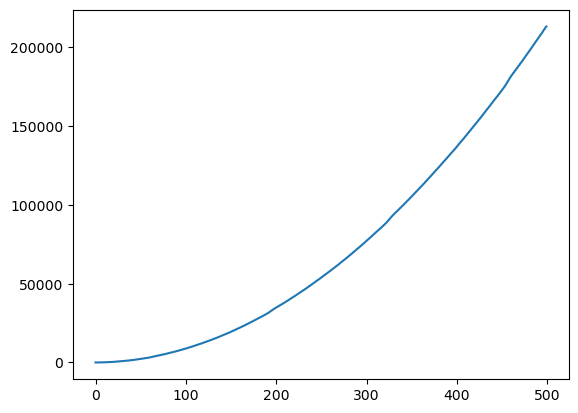

In [180]:
plt.plot(steps, values)
plt.show()

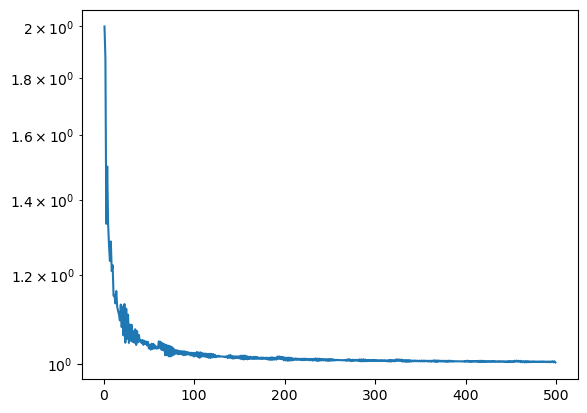

In [181]:
plt.plot(step_delta, value_divide)
plt.yscale("log")
plt.show()

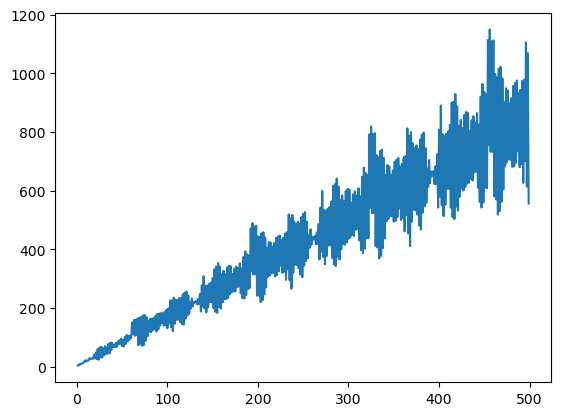

In [182]:
plt.plot(step_delta, value_subtract)
plt.show()

Observation: Period of 11 for the test data.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

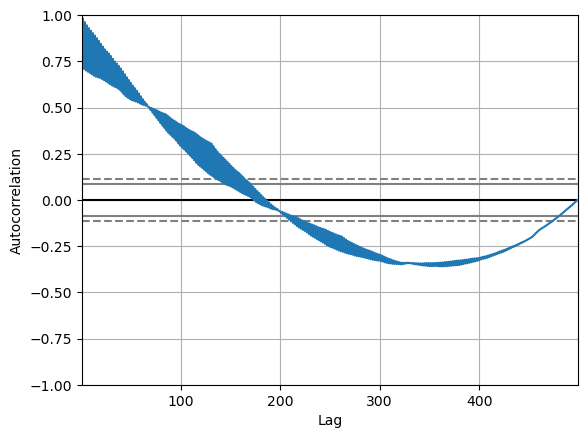

In [183]:
autocorrelation_plot(value_subtract)
#plt.xlim(0, 20)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:              ARIMA([11], 2, 0)   Log Likelihood               -3019.601
Date:                Fri, 22 Dec 2023   AIC                           6043.203
Time:                        14:18:58   BIC                           6051.624
Sample:                             0   HQIC                          6046.508
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L11        -0.8687      0.020    -43.857      0.000      -0.908      -0.830
sigma2      1.049e+04    550.060     19.073      0.000    9413.323    1.16e+04
Ljung-Box (L1) (Q):                 418.26   Jarque-

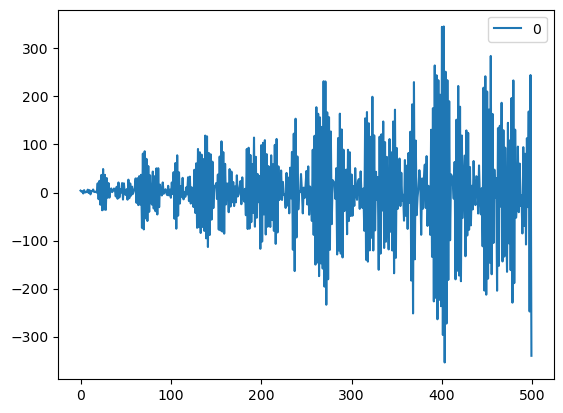

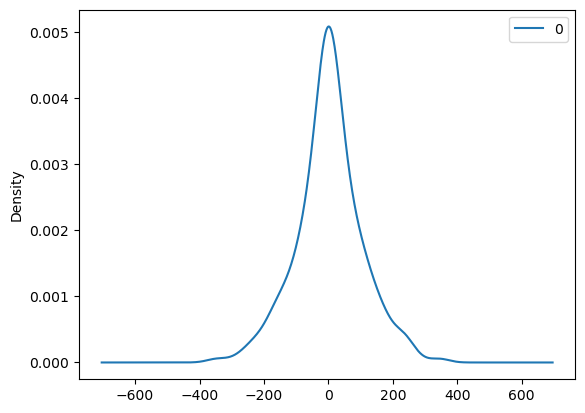

                0
count  500.000000
mean     2.728625
std    102.282660
min   -353.899993
25%    -47.420372
50%      1.803158
75%     55.021931
max    345.749983


In [184]:
# fit model
model = ARIMA(values, order=((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1), 2, 0))
#model = ARIMA(values, order=(11, 2, 0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [185]:
lag_feature = step_delta % 11
lag_feature = pd.get_dummies(lag_feature, drop_first=False).to_numpy()

In [186]:
X = step_delta
X = sm.add_constant(X)
X = np.hstack((X, lag_feature))
Y = value_subtract

In [187]:
ols_model = sm.OLS(Y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     250.4
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.94e-192
Time:                        14:19:09   Log-Likelihood:                -3020.9
No. Observations:                 499   AIC:                             6066.
Df Residuals:                     487   BIC:                             6116.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9958      8.573      0.233      0.816     -14.848      18.840
x1             1.7008      0.032     52.473      0.000       1.637       1.764
x2            -2.8945     14.843     -0.195      0.845     -32.059      26.270
x3             1.6199     14.688      0.110      0.912     -27.240      30.480
x4            -1.7765     14.690     -0.121      0.904     -30.639      27.086
x5             2.3053     14.691      0.157      0.875     -26.560      31.171
x6            -1.8303     14.693     -0.125      0.901     -30.699      27.039
x7            -3.7564     14.835     -0.253      0.800     -32.904      25.391
x8             5.1872     14.836      0.350      0.727     -23.963      34.337
x9             0.4420     14.837      0.030      0.976     -28.711      29.595
x10            4.5634     14.839      0.308      0.759     -24.592      33.719
x11            0.1515     14.840      0.010      0.992     -29.007      29.310
x12           -2.0159     14.842     -0.136      0.892     -31.178      27.146
==============================================================================
Omnibus:                        6.129   Durbin-Watson:                   3.704
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.355
Skew:                           0.199   Prob(JB):                       0.0417
Kurtosis:                       3.383   Cond. No.                     4.53e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

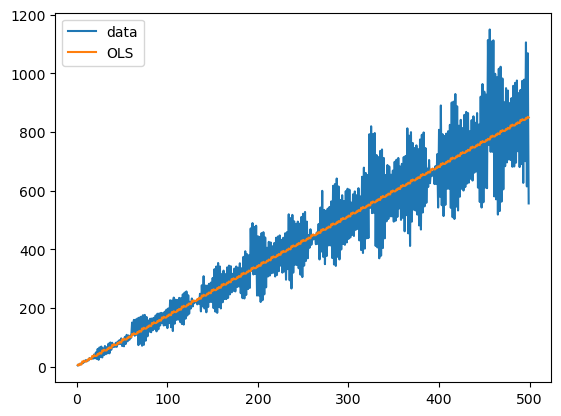

In [188]:
plt.plot(step_delta, Y, label = "data")
plt.plot(step_delta, results.predict(X), label = "OLS")
plt.legend()
plt.show()

In [194]:
df = pd.DataFrame({"steps": steps, "values": values})

In [195]:
df

steps  values
0        0       4
1        1       8
2        2      15
3        3      20
4        4      30
..     ...     ...
495    495  209920
496    496  211025
497    497  211639
498    498  212707
499    499  213263

[500 rows x 2 columns]

In [163]:
df.to_csv("test_results.csv", index=False)

In [200]:
x = read_input("input.txt")
len(np.where(x == ".")[0])

14597

In [201]:
df[df["values"] % 14597 == 0]

steps  values
413    413  145970